## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
# Import necessary packages and suppress warnings
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
# Read in csv of cleaned data 
df = pd.read_csv('priv_data_clean.csv')
df.head()

,index,Location,Country,Aircraft.damage,Make,Model,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,...,Total.Passengers,Total.Injured,Percent.Injured,Percent.Uninjured,Percent.Died,Airplane.Type,Event.Day,Event.Month,Event.Month.Name,Event.Year
0,0,ID,United States,Destroyed,Stinson,108-3,1.0,Reciprocating,Personal,2.0,...,2.0,2.0,100.000000,0.000000,100.0,Private,24,10,October,1948
1,1,CA,United States,Destroyed,Piper,Pa24-180,1.0,Reciprocating,Personal,4.0,...,4.0,4.0,100.000000,0.000000,100.0,Private,19,7,July,1962
2,2,VA,United States,Destroyed,Cessna,172M,1.0,Reciprocating,Personal,3.0,...,3.0,3.0,100.000000,0.000000,100.0,Private,30,8,August,1974
3,3,CA,United States,Destroyed,Rockwell,112,1.0,Reciprocating,Personal,2.0,...,2.0,2.0,100.000000,0.000000,100.0,Private,19,6,June,1977
4,4,MA,United States,Substantial,Mcdonnel Douglas,Dc9,2.0,Turbo Fan,Unknown,0.0,...,45.0,1.0,2.222222,97.777778,0.0,Private,17,9,September,1979


## Visualize KPIs

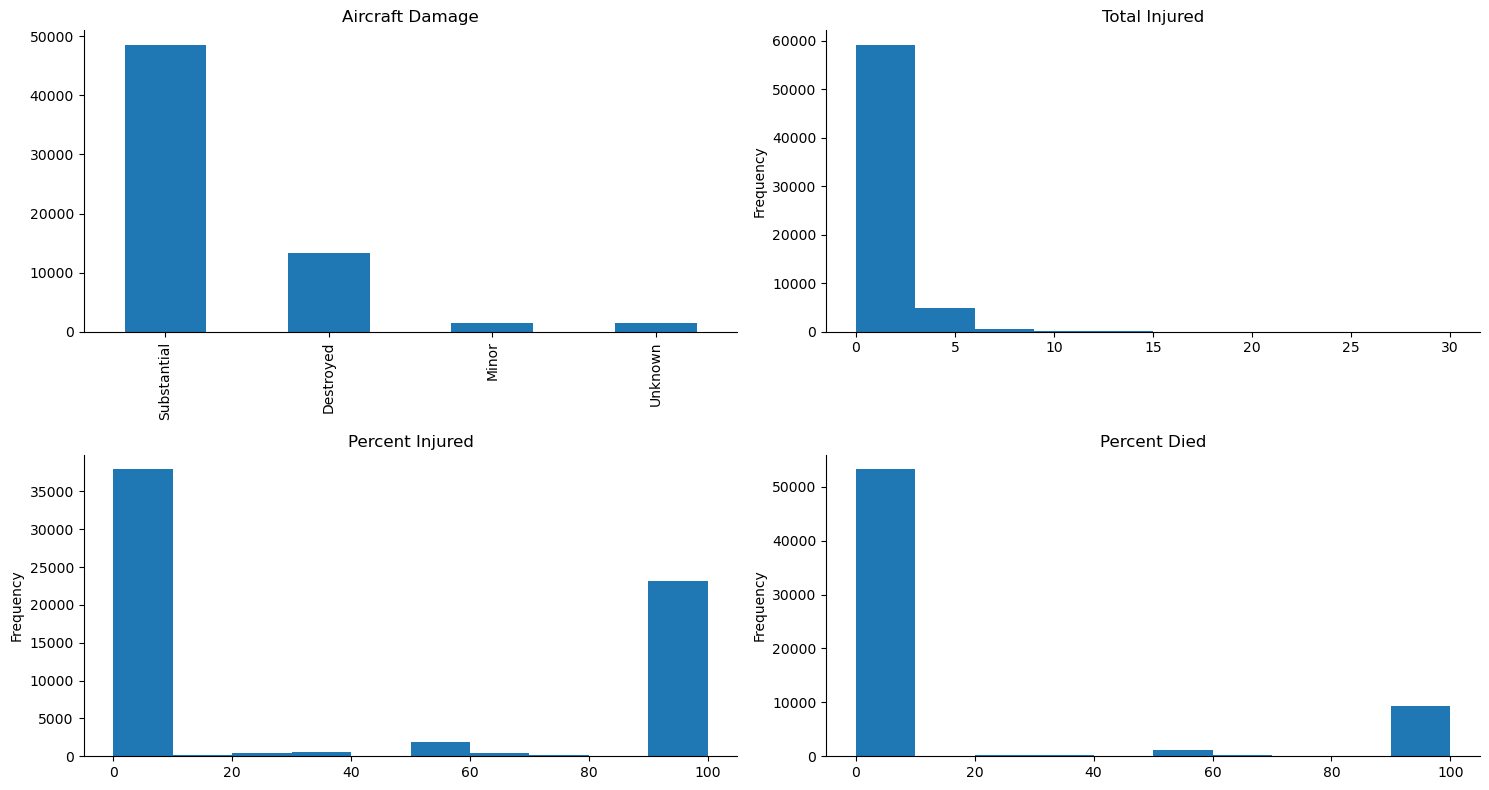

In [3]:
# Visualize distribution of key variables
fig, ax = plt.subplots(2,2, figsize = ((15,8)))

# Aircraft Damage
df['Aircraft.damage'].value_counts().plot.bar(ax=ax[0,0]);
ax[0, 0].set_title("Aircraft Damage")
ax[0, 0].set_xlabel("")

# Total Injured
df['Total.Injured'].plot.hist(ax=ax[0,1], range=[0,30])
ax[0, 1].set_title("Total Injured")
ax[0, 1].set_xlabel("")

# Percent Injured
df['Percent.Injured'].plot.hist(ax=ax[1,0])
ax[1, 0].set_title("Percent Injured")
ax[1, 0].set_xlabel("")

# Percent Died
df['Percent.Died'].plot.hist(ax=ax[1,1]);
ax[1, 1].set_title("Percent Died")
ax[1, 1].set_xlabel("")

plt.tight_layout()
sns.despine()

In [4]:
# Generate and print a list of all the popular makes in the dataset
# Note that the cleaned csv only includes incidents involving the top 50 makes 

popular_makes = list(df['Make'].value_counts().index)
print(f"top makes: {popular_makes}")

top makes: ['Cessna', 'Piper', 'Beech', 'Bell', 'Boeing', 'Mooney', 'Grumman', 'Bellanca', 'Hughes', 'Air Tractor', 'Aeronca', 'Schweizer', 'Maule', 'Mcdonnel Douglas', 'Champion', 'Stinson', 'Cirrus', 'Luscombe', 'Aero Commander', 'Taylorcraft', 'De Havilland', 'North American', 'Aerospatiale', 'Hiller', 'Rockwell', 'Airbus', 'Enstrom', 'Grumman American', 'Ayres', 'Embraer', 'Sikorsky', 'Swearingen', 'Ercoupe Eng & Research Corp', 'Fairchild', 'Lake', 'Waco', 'Mitsubishi', 'Aviat', 'Bombardier', 'GrummanSchweizer', 'Socata', 'Ryan', 'Helio', 'Learjet', 'Schleicher', 'Dehavilland', 'Globe', 'Weatherly', 'Wsk Pzl Mielec', 'Lockheed']


## Damage Index

Each row in the dataset contains information about an aircraft accident. Here, we calculate a damage index to quantify how destructive the accidents were for a particular Make of aircraft. The damage index considers the ratio of planes of a particular Make that were destroyed in the incident, compared to the ratio of planes that with substantial damage and minor damage. 

We assume an exponential relationship between levels of aircraft damage, such that incidents with substantial damage are twice as bad as those with minor damage, but incidents with destroyed planes are four times as bad as those with minor damage. 

The damage index formula is as follows: (ratio destroyed x 4) + (ratio subtantial x 2) + (ratio minor x 1).

In [5]:
# Create a new df for calculating the damage index. In this dataframe, "Unknown" 
# values in the Aircraft Damage column will be randomly assigned a value 

# Find the indices of all unknown values in Aircraft Damage 
unk_indices = list(df.loc[df['Aircraft.damage'] == 'Unknown'].index)

# Calculate the probability of observing each value in the current dataset
damage_probs = df['Aircraft.damage'].value_counts()
damage_probs = damage_probs.drop('Unknown')
damage_probs = damage_probs / damage_probs.sum()

# Randomly generate new values for Aircraft Damage based on probabilities observed in known dataset 
rand_damage = np.random.choice(list(damage_probs.index), size = len(unk_indices), p = list(damage_probs))

# Create a new dataset with the new unknown values in Aircraft Damage replaced 
adj_df = df.copy()
adj_df['Aircraft.damage'].iloc[unk_indices] = rand_damage

In [6]:
# Create a df for the damage index 

di_df = pd.DataFrame(columns = ['Damage_Index', 'Num.Incidents.Make', 'Uninjured_P', 'Injured_P', 'Died_P'], )
pop_means_df = adj_df.groupby('Make').mean(numeric_only=True)

for make in popular_makes:
    make_info = adj_df[adj_df['Make'] == make]['Aircraft.damage'].value_counts(normalize=True)

    if 'Minor' not in make_info.index:
        make_info['Minor'] = 0

    damage_index = (make_info['Destroyed'] * 4) + (make_info['Substantial'] * 2) + (make_info['Minor'] * 1)

    # Add additional relevant info to damage index df 
    num_incidents = adj_df['Make'].value_counts()[make]
    make_stats = list(pop_means_df.loc[make].reindex(['Percent.Uninjured', 'Percent.Injured', 'Percent.Died']))
    di_df.loc[make] =[damage_index, num_incidents] + make_stats

In [7]:
# Adjust the damage index by penalizing Makes with too few datapoints (n) 
# All with makes with n < threshold are penalized 

threshold = 1000
penalty_rate = 0.5
di_df['Penalty'] = di_df['Num.Incidents.Make'].apply(lambda x: 1 + penalty_rate * np.log(threshold/x) if x < threshold else 1)
di_df['Adj_Damage_Index'] = di_df['Damage_Index'] * di_df['Penalty'] 
di_df.sort_values(by = 'Adj_Damage_Index')

,Damage_Index,Num.Incidents.Make,Uninjured_P,Injured_P,Died_P,Penalty,Adj_Damage_Index
Boeing,2.071958,1348.0,77.379048,13.644691,4.119794,1.000000,2.071958
Cessna,2.357726,26101.0,64.282062,35.599169,14.184457,1.000000,2.357726
Piper,2.438863,14353.0,58.750565,41.165828,18.580916,1.000000,2.438863
Bellanca,2.440430,1024.0,55.102539,44.897461,18.953451,1.000000,2.440430
Bell,2.477433,2415.0,52.612850,47.014479,14.632809,1.000000,2.477433
Grumman,2.496954,1149.0,66.232287,33.767713,9.495173,1.000000,2.496954
Air Tractor,2.345708,862.0,59.416087,40.583913,14.365816,1.074250,2.519876
Hughes,2.384615,884.0,57.882730,42.004148,10.337481,1.061649,2.531625
Mooney,2.535549,1294.0,48.377125,51.468315,26.009789,1.000000,2.535549
Beech,2.550511,5088.0,54.217529,45.546621,25.925133,1.000000,2.550511


In [8]:
# Identify the top three makes based on the damage index 
top3makes = list(di_df.sort_values(by = 'Adj_Damage_Index').index[:3])
print(top3makes)

# Add new column to df indicating whether the incident involves a Make in the top 3
df['DI.Top3'] = df['Make'].apply(lambda x: x in top3makes)

['Boeing', 'Cessna', 'Piper']


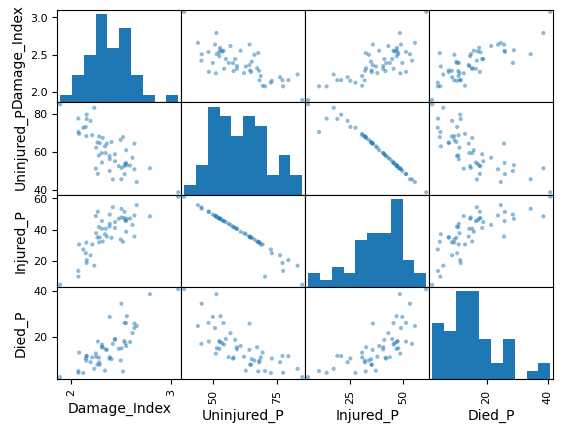

In [9]:
# Validate the damage index by plotting it against key metrics to observe relationships between the variables 
pd.plotting.scatter_matrix(di_df[['Damage_Index', 'Uninjured_P', 'Injured_P', 'Died_P']]);

## Model Performance

In addition to understanding which planes are likely to have destructive incidents, we are also interested in which planes have better outcomes for people when they are involved in such incidents. 

To this end, we calculated the performance of each model of plane as a function of whether people had positive outcomes following the incident. 

For planes that had substantial damage or were destroyed, performance was marked as positive if there were no fatalities. 
For planes that had minor damage, performance was marked as positive if there were no fatalities or injuries. 

An overall performance score is generated by calculating the fraction of incidents that met the positive performance criteria over the total number of incidents for each model. 

In [10]:
# Subset the df to select for incidents that meet the positive performance criteria
best_dest = df.loc[(df['Aircraft.damage'] == 'Destroyed') & (df['Percent.Died'] == 0) & (df['Event.Year'] > 1989) & (df['Total.Passengers'] != 0)]
best_subs = df.loc[(df['Aircraft.damage'] == 'Substantial') & (df['Percent.Died'] == 0) & (df['Event.Year'] > 1989) & (df['Percent.Injured'] == 0) & (df['Total.Passengers'] != 0)]
best_minor = df.loc[(df['Aircraft.damage'] == 'Minor') & (df['Percent.Died'] == 0) & (df['Percent.Injured'] == 0) & (df['Event.Year'] > 1989) & (df['Total.Passengers'] != 0)]


In [11]:
# Calculate an overal performance score for each model by calculating 
# the fraction of incidents that met the positive performance criteria 
# divided by the total number of incidents for each model.

d_d = best_dest['Model'].value_counts().to_dict()
d_s = best_subs['Model'].value_counts().to_dict()
d_m = best_minor['Model'].value_counts().to_dict()
all_keys = set()
all_keys.update(d_d.keys())
all_keys.update(d_s.keys())
all_keys.update(d_m.keys())
r_d  = {}
for key in all_keys:
    r_d[key] = d_d.get(key, 0) + d_s.get(key, 0) + d_m.get(key, 0)
result_d = {}
for key in all_keys:
    denominator = df['Model'].value_counts().to_dict().get(key, 1)
       
    if denominator != 0:
        result_d[key] = r_d[key] / denominator
    else:
        result_d[key] = 0 

In [12]:
# Convert the performance dictionary into a pandas series 
model_performance = pd.Series(result_d)
model_performance

Tr182Rg        0.250000
767-332Er      0.500000
M-4-210C       0.333333
B777           1.000000
Calair A-9B    0.500000
                 ...   
320            0.444444
500E           0.666667
J-3 Cub        0.333333
20             0.500000
Tb-25N         0.500000
Length: 2800, dtype: float64

In [13]:
# Confirm there are no null values within the model performance series 
model_performance.isna().sum()

0

## Create CSVs

In [15]:
# Add a df summarizing performance and number of incidents for each model 
model_vc = df['Model'].value_counts()
model_pwdc = pd.concat({'Performance': model_performance, 'Num.Incidents.Model': model_vc}, axis=1)

# Add performance and damage index info to df 
df = df.join(model_pwdc, how='outer',on='Model')
df = df.join(di_df, how='outer', on='Make')

# Remove all models with too few datapoints (20 or fewer) 
df = df.loc[df['Num.Incidents.Model'] >= 20]

In [19]:
# Create a df with each model, make, it's performance score, it's corresponding make, and whether that make is top3 
make_model = model_pwdc.reset_index()
make_model = make_model[make_model['Num.Incidents.Model'] > 20].reset_index(drop=True)
make_model = make_model.rename(columns={'index': 'Model'})
make_model = make_model.merge(df.loc[:,['Make', 'Model']], how='left',on='Model')
make_model = make_model.drop_duplicates(subset='Model', keep='first').reset_index(drop=True)
make_model['Top3'] = make_model['Make'].apply(lambda x: x in top3makes)
make_model

,Model,Performance,Num.Incidents.Model,Make,Top3
0,17-31Atc,0.260870,23,Bellanca,False
1,Pa-32-260,0.331858,226,Piper,True
2,Pa28,0.570833,240,Piper,True
3,T210N,0.312236,237,Cessna,True
4,Dc-9-32,0.193548,31,Mcdonnel Douglas,False
...,...,...,...,...,...
488,Pa32R,0.548387,31,Piper,True
489,47G,0.372340,94,Bell,False
490,R172K,0.397849,93,Cessna,True
491,208B,0.447552,143,Cessna,True


In [20]:
# Filter for Models within top3makes 
top_make_model = make_model[make_model['Top3']==True]

best_models = []

for make in top3makes:
    
    # Filter for all Models within one Make 
    subset = top_make_model[top_make_model['Make'] == make]
    
    # Extract best 3 Models within one Make (based on performance) 
    subset = subset.sort_values(by='Performance', ascending = False)['Model'][:3]

    best_models.extend(list(subset))

print(best_models)

['B75N1', 'A75N1(Pt17)', 'E75', 'A185', '172R', '172S', 'Pa-18-160', 'Pa 12', 'Pa18']


In [21]:
# Add a new column to the df indicating whether the incident involved a top model
df['Top.Model'] = df['Model'].apply(lambda x: x in best_models)
df.head()

,index,Location,Country,Aircraft.damage,Make,Model,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,...,Performance,Num.Incidents.Model,Damage_Index,Num.Incidents.Make,Uninjured_P,Injured_P,Died_P,Penalty,Adj_Damage_Index,Top.Model
0,0,ID,United States,Destroyed,Stinson,108-3,1.0,Reciprocating,Personal,2.0,...,0.494845,97,2.263761,436.0,64.908257,35.091743,7.64526,1.415057,3.20335,False
1084,1084,KY,United States,Substantial,Stinson,108-3,1.0,Reciprocating,Personal,0.0,...,0.494845,97,2.263761,436.0,64.908257,35.091743,7.64526,1.415057,3.20335,False
1438,1438,WA,United States,Destroyed,Stinson,108-3,1.0,Reciprocating,Personal,0.0,...,0.494845,97,2.263761,436.0,64.908257,35.091743,7.64526,1.415057,3.20335,False
2767,2767,WA,United States,Destroyed,Stinson,108-3,1.0,Reciprocating,Personal,2.0,...,0.494845,97,2.263761,436.0,64.908257,35.091743,7.64526,1.415057,3.20335,False
3985,3985,WY,United States,Substantial,Stinson,108-3,1.0,Reciprocating,Personal,0.0,...,0.494845,97,2.263761,436.0,64.908257,35.091743,7.64526,1.415057,3.20335,False


In [22]:
# Create a new dataframe with only the best performing models 
df_top_models = df.loc[df['Top.Model']==True].reset_index(drop=True)
df_top_models

,index,Location,Country,Aircraft.damage,Make,Model,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,...,Performance,Num.Incidents.Model,Damage_Index,Num.Incidents.Make,Uninjured_P,Injured_P,Died_P,Penalty,Adj_Damage_Index,Top.Model
0,12777,IA,United States,Substantial,Piper,Pa18,1.0,Reciprocating,Personal,0.0,...,0.758621,87,2.438863,14353.0,58.750565,41.165828,18.580916,1.0,2.438863,True
1,21782,WA,United States,Substantial,Piper,Pa18,1.0,Reciprocating,Personal,0.0,...,0.758621,87,2.438863,14353.0,58.750565,41.165828,18.580916,1.0,2.438863,True
2,39167,OR,United States,Destroyed,Piper,Pa18,1.0,Reciprocating,Personal,0.0,...,0.758621,87,2.438863,14353.0,58.750565,41.165828,18.580916,1.0,2.438863,True
3,52517,Unknown/Foreign Location,Foreign Country,Destroyed,Piper,Pa18,1.0,Reciprocating,Personal,2.0,...,0.758621,87,2.438863,14353.0,58.750565,41.165828,18.580916,1.0,2.438863,True
4,52601,AZ,United States,Substantial,Piper,Pa18,1.0,Reciprocating,Instructional,0.0,...,0.758621,87,2.438863,14353.0,58.750565,41.165828,18.580916,1.0,2.438863,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,63564,Unknown/Foreign Location,Foreign Country,Substantial,Boeing,A75N1(Pt17),1.0,Unknown,Personal,0.0,...,0.625000,32,2.071958,1348.0,77.379048,13.644691,4.119794,1.0,2.071958,True
869,63738,OF,Foreign Country,Unknown,Boeing,A75N1(Pt17),1.0,Unknown,Unknown,0.0,...,0.625000,32,2.071958,1348.0,77.379048,13.644691,4.119794,1.0,2.071958,True
870,64567,OK,United States,Substantial,Boeing,A75N1(Pt17),1.0,Reciprocating,Personal,0.0,...,0.625000,32,2.071958,1348.0,77.379048,13.644691,4.119794,1.0,2.071958,True
871,64685,CA,United States,Substantial,Boeing,A75N1(Pt17),1.0,Unknown,Personal,0.0,...,0.625000,32,2.071958,1348.0,77.379048,13.644691,4.119794,1.0,2.071958,True
